# LIS DQN 画像入力
学習済みネットワークを使わずに画像をQNetworkの入力としている

In [1]:
# GYM
import sys
tmp_path = []
for it in sys.path:
    if not 'gym' in it:
        # print(it)
        tmp_path.append(it)
sys.path = tmp_path
sys.path.append('../..')
# faster rcnn
import sys
sys.path.append('../../../../chainer-faster-rcnn')
from lib.cpu_nms import cpu_nms as nms
from lib.models.faster_rcnn import FasterRCNN
import cv2 as cv

In [2]:
from __future__ import print_function
import copy
import os
import random
import collections
import numpy as np
import six.moves.cPickle as pickle

import gym
from PIL import Image

import chainer
from chainer import cuda, FunctionSet, Variable, optimizers
from chainer import links as L
import chainer.functions as F
from chainer.links import caffe

%matplotlib notebook
import matplotlib.pyplot as plt
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


# QNet

In [3]:
class QFunction(chainer.Chain):

    def __init__(self, n_actions):
        initializer = chainer.initializers.HeNormal()
        c1 = 32
        c2 = 64
        c3 = 64
        fc_unit = 256*2

        super(QFunction, self).__init__(
             # the size of the inputs to each layer will be inferred
            conv1=L.Convolution2D(4, c1, 8, stride=4, pad=0),
            conv2=L.Convolution2D(c1, c2, 4, stride=2, pad=0),
            conv3=L.Convolution2D(c2, c2, 4, stride=2, pad=0),
            conv4=L.Convolution2D(c2, c3, 3, stride=1, pad=0),
            fc1=L.Linear(6400, fc_unit, initialW=initializer),
            fc2=L.Linear(fc_unit, n_actions, initialW=initializer),
        )

    def __call__(self, x):
        x = x/255.
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.fc1(h))
        y = self.fc2(h)        
        return y

In [4]:
def get_greedy_action(Q, obs):
    xp = Q.xp
    obs = xp.expand_dims(xp.asarray(obs, dtype=np.float32), 0)
    with chainer.no_backprop_mode():
        q = Q(obs).data[0]
    return int(xp.argmax(q))

In [5]:
def mean_clipped_loss(y, t):
    # Add an axis because F.huber_loss only accepts arrays with ndim >= 2
    y = F.expand_dims(y, axis=-1)
    t = F.expand_dims(t, axis=-1)
    return F.sum(F.huber_loss(y, t, 1.0)) / y.shape[0]

In [6]:
def update(Q, target_Q, opt, samples, gamma=0.99, target_type='dqn'): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
    r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
    done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
    s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0]
        s_next[i] = samples[i][4]

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)
    r = xp.asarray(r)
    done = xp.asarray(done)
    s_next = xp.asarray(s_next)
    
    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    # Target: r + gamma * max Q_b (s',b)
    with chainer.no_backprop_mode():
        if target_type == 'dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.max(target_Q(s_next), axis=1)
        elif target_type == 'double_dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.select_item(
                target_Q(s_next), F.argmax(Q(s_next), axis=1))
        else:
            raise ValueError('Unsupported target_type: {}'.format(target_type))
    loss = mean_clipped_loss(y, t)
    Q.cleargrads()
    loss.backward()
    opt.update()

In [7]:
def meanQvalue(Q, samples): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0]

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)

    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    mean_Q = (F.sum(y)/minibatch_size).data
    return mean_Q
  

# 入力画像をStateへ変換

In [8]:
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network
FRAME_WIDTH = 224  # Resized frame width
FRAME_HEIGHT = 224  # Resized frame height
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize

class ObsProcesser:
    mean_file = 'ilsvrc_2012_mean.npy'
    mean_name, ext = os.path.splitext(mean_file)

    def __init__(self):
        self.state = None
            
    def init_state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        state = [processed_obs for _ in xrange(STATE_LENGTH)]
        self.state = np.stack(state, axis=0)
        
    def obs2state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        self.state = np.concatenate((self.state[1:, :, :], processed_obs[np.newaxis]), axis=0)
        return self.state
    
    def _preprocess_observation(self, obs):
        img = np.array(obs["image"][0])
        preprossed = np.asarray(resize(rgb2gray(img), (FRAME_WIDTH, FRAME_HEIGHT))*255, dtype=np.uint8)
        return preprossed
    

In [9]:
def obs2image(obs):
    return np.array(obs['image'][0])

# ロボットから情報から椅子の世界座標系の位置（x, z）を求める
## カメラの設定

In [10]:
INPUT_IMAGE_HEIGTH = 224
INPUT_IMAGE_WIDTH = 224

EYE_HEIGHT = 1.12
EYE_FOV = np.pi/2
FOCUS_LENGTH = INPUT_IMAGE_HEIGTH/(2*np.tan(EYE_FOV/2))

#どれくらいずれていても椅子とみなすか [m]
CHAIR_TH = 0.8

In [11]:
def estimateChairPosition(x1, y1, x2, y2, info):
    # 椅子検知した四角の下辺中央の座標
    xb=x1+(x2-x1)/2
    if y2 < INPUT_IMAGE_HEIGTH/2:
        print('not chair')
        return
    # 左下原点のimage座標系へ変換
    image_pos = np.array([xb, INPUT_IMAGE_HEIGTH - y2])
    
    # 画像上の中心からの距離
    diff_pos = image_pos - np.array([INPUT_IMAGE_HEIGTH/2, INPUT_IMAGE_WIDTH/2])
    # 光線ベクトルへ
    ray = np.append(diff_pos, FOCUS_LENGTH)
    ray = ray / np.linalg.norm(ray)  
    # 光線ベクトルと地面との交点を算出
    if ray[1] > 0:
        print('not chair')
        return 
    scale = EYE_HEIGHT/(-ray[1])
    chair_from_agent = scale*ray[[0,2]]
    
    # Agentの情報
    agent_pos = info['agent_info']['pos'][[0,2]]
    agent_angle = np.deg2rad(info['agent_info']['angle'][1])
    # Rotation
    R = np.array([[np.cos(-agent_angle), -np.sin(-agent_angle)],
                  [np.sin(-agent_angle), np.cos(-agent_angle)]])
    # 世界座標系からみた椅子の位置
    chair_pos = agent_pos + np.dot(R, chair_from_agent)
    return chair_pos

# 椅子検知器

In [12]:
class ChairDetector():
    CLASSES = ('__background__',
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')
    CHAIR_ID = 9
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])

    def __init__(self, gpu=-1):
        pickle_file = 'data/VGG16_faster_rcnn_final.pickle'
        if os.path.exists(pickle_file):
            print("loading... " + pickle_file),
            self.model = pickle.load(open(pickle_file))
            print("done")
        else:
            self.model = FasterRCNN(gpu)
            serializers.load_npz('data/VGG16_faster_rcnn_final.model', self.model)
            pickle.dump(self.model, open(pickle_file, 'wb'),-1)
            print("pickle.dump finished")
        
        self.model.train = False
        if chainer.cuda.available and gpu >= 0:
            self.model.to_gpu(gpu)
        self.gpu = gpu
        
    def forward(self, orig_image):
        img, im_scale = self.img_preprocessing(orig_image, self.PIXEL_MEANS)
        img = np.expand_dims(img, axis=0)
        if self.gpu >= 0:
            img = cuda.to_gpu(img, device=self.gpu)
        img = chainer.Variable(img, volatile=True)
        h, w = img.data.shape[2:]
        cls_score, bbox_pred = self.model(img, np.array([[h, w, im_scale]]))
        cls_score = cls_score.data
        return cls_score, bbox_pred, im_scale

    def img_preprocessing(self, orig_img, pixel_means, max_size=1000, scale=600):
        img = orig_img.astype(np.float32, copy=True)
        img -= pixel_means
        im_size_min = np.min(img.shape[0:2])
        im_size_max = np.max(img.shape[0:2])
        im_scale = float(scale) / float(im_size_min)
        if np.round(im_scale * im_size_max) > max_size:
            im_scale = float(max_size) / float(im_size_max)
        img = cv.resize(img, None, None, fx=im_scale, fy=im_scale,
                        interpolation=cv.INTER_LINEAR)

        return img.transpose([2, 0, 1]).astype(np.float32), im_scale


    def detect_chair_bbox(self, img, nms_thresh=0.3, conf=0.8):
        cls_score, bbox_pred, im_scale = self.forward(img)
        if self.gpu >= 0:
            self.clss = chainer.cuda.cupy.asnumpy(cls_score)
            self.bbox = chainer.cuda.cupy.asnumpy(bbox_pred)
        
        CV_AA = 16
        fontScale = 0.8
        
        cls_id = self.CHAIR_ID
        _cls = self.clss[:, cls_id][:, np.newaxis]
        _bbx = self.bbox[:, cls_id * 4: (cls_id + 1) * 4]
        dets = np.hstack((_bbx, _cls))
        keep = nms(dets, nms_thresh)
        dets = dets[keep, :]

        inds = np.where(dets[:, -1] >= conf)[0]
        chair_bbox = []
        for i in inds:
            x1, y1, x2, y2 = map(int, dets[i, :4])
            chair_bbox.append((x1, y1, x2, y2))
        return chair_bbox
 
    def calculate_reward(self, obs, info):
        self.input_image = obs2image(obs)
        chair_bbox = self.detect_chair_bbox(self.input_image)

        chair_positions = []
        for x1, y1, x2, y2 in chair_bbox:
            pos = estimateChairPosition(x1, y1, x2, y2, info)
            if pos is not None:
                chair_positions.append(pos)
                # print('detect chair position : {}'.format(pos))

        groudtruth_chair_pos = np.array([it[[0,2]] for it in info['obj_info']['pos']])

        chair_ids = []
        for estimate in chair_positions:
            # 距離の測定
            diff = np.linalg.norm(groudtruth_chair_pos - estimate, axis=1)
            tmp_index = np.argmin(diff)
            # 閾値以下だったら認識が正しい
            if diff[tmp_index] < CHAIR_TH:
                chair_ids.append(int(info['obj_info']['id'][tmp_index]))
                #print('chair id {}:{}'.format(chair_ids[-1], estimate))
        
        return len(chair_ids), chair_ids
    
    def draw_result(self, img, nms_thresh=0.3, conf=0.8):
        cls_score, bbox_pred, im_scale = self.forward(img)
        if self.gpu >= 0:
            clss = chainer.cuda.cupy.asnumpy(cls_score)
            bbox = chainer.cuda.cupy.asnumpy(bbox_pred)
        
        CV_AA = 16
        fontScale = 0.5
        result = img.copy()
        for cls_id in range(1, 21):
            _cls = clss[:, cls_id][:, np.newaxis]
            _bbx = bbox[:, cls_id * 4: (cls_id + 1) * 4]
            dets = np.hstack((_bbx, _cls))
            keep = nms(dets, nms_thresh)
            dets = dets[keep, :]

            inds = np.where(dets[:, -1] >= conf)[0]
            for i in inds:
                x1, y1, x2, y2 = map(int, dets[i, :4])
                cv.rectangle(result, (x1, y1), (x2, y2), (0, 0, 255), 2, CV_AA)
                disp_text = "{0}:{1:.3f}".format(self.CLASSES[cls_id], dets[i, 4])
                ret, baseline = cv.getTextSize( disp_text, cv.FONT_HERSHEY_SIMPLEX, fontScale, 1)
                cv.rectangle(result, (x1, y2 - ret[1] - baseline),
                             (x1 + ret[0], y2), (0, 0, 255), -1)
                cv.putText(result, disp_text, (x1, y2 - baseline),
                           cv.FONT_HERSHEY_SIMPLEX, fontScale, (255, 255, 255), 1, CV_AA)

        #result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
        return result
    
    def draw_chair(self, nms_thresh=0.3, conf=0.8):
        '''
            this function must be called after calculate_reward
            self.input_image, self.clss and self.bbox are updated in calculate_reward
        '''
        CV_AA = 16
        fontScale = 0.5
        result = self.input_image.copy()
        
        cls_id = self.CHAIR_ID
        _cls = self.clss[:, cls_id][:, np.newaxis]
        _bbx = self.bbox[:, cls_id * 4: (cls_id + 1) * 4]
        dets = np.hstack((_bbx, _cls))
        keep = nms(dets, nms_thresh)
        dets = dets[keep, :]

        inds = np.where(dets[:, -1] >= conf)[0]
        for i in inds:
            x1, y1, x2, y2 = map(int, dets[i, :4])
            cv.rectangle(result, (x1, y1), (x2, y2), (0, 0, 255), 2, CV_AA)
            disp_text = "{0:.3f}".format(dets[i, 4])
            ret, baseline = cv.getTextSize( disp_text, cv.FONT_HERSHEY_SIMPLEX, fontScale, 1)
            cv.rectangle(result, (x1, y2 - ret[1] - baseline),
                         (x1 + ret[0], y2), (0, 0, 255), -1)
            cv.putText(result, disp_text, (x1, y2 - baseline),
                       cv.FONT_HERSHEY_SIMPLEX, fontScale, (255, 255, 255), 1, CV_AA)

        #result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
        return result


# Debug用

In [13]:
def loadObs():
    img = Image.open('chair_image.png')
    dep = Image.open('chair_depth.png')

    obs={}
    obs['image'] = [img]
    obs['depth'] = [dep]
    return obs

In [14]:
def saveObs(obs):
    obs['image'][0].save('chair_image.png')
    obs['depth'][0].save('chair_depth.png')

In [15]:
# obs = loadObs()
# obs

In [16]:
#saveObs(obs)

# Lis_DQN

In [17]:
# Initialize variables
depth_image_dim = 224 * 224
M = 10000  # number of episodes
replay_start_size = 1000  # steps after which we start to update
steps_to_decay_epsilon = 25000  # steps to take to decay epsilon
min_epsilon = 0.1  # minimum value of epsilon
sync_interval = 2000  # interval of target sync
evaluation_interval = 50 # 何エピソードごとに評価するか
update_inverval = 1
minibatch_size = 32  # size of minibatch
reward_scale = 1  # scale factor for rewards
gpu = 0  # gpu id (-1 to use cpu)
target_type = 'dqn'  # 'dqn' or 'double_dqn'
#NO_OP_MAX = 10 # maximum number of "do anything" actions at the start of an episode
save_model_inverval = 3000 # interval of save weights
save_folder = 'checkpoints_EpiLen25'
D = collections.deque(maxlen=10 ** 5)  # replay memory: original 10 ** 6

Rs = []  # past returns
average_Rs = []
eval_Rs = [] # evaluation Max reward
eval_steps = [] # evaluation Max
step = 0  # total steps taken
episode = 0

networkname = 'image_input'
log_file = os.path.join(save_folder,'reward_'+networkname+'.log')

In [18]:
# disable stderre
import os
import sys
f = open(os.devnull, 'w')
sys.stderr = f
# 開始の時間表示
from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
# save folder
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
# log file
with open(log_file, 'w') as the_file:
    the_file.write('cycle, episode_reward_sum \n')

2017/01/20 23:15:37


# Initialize

In [19]:
enable_controller = [0,1,2]
n_actions = len(enable_controller)
obs_processer = ObsProcesser()
# 
chair_detector = ChairDetector(gpu)

loading... data/VGG16_faster_rcnn_final.pickle
done


In [20]:
# Initialize chainer models
Q = QFunction(n_actions)
if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    Q.to_gpu(gpu)
target_Q = copy.deepcopy(Q)
opt = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.95, eps=0.0001)
opt.setup(Q)

In [21]:
env_name = 'Lis-v2'
env = gym.make(env_name)
obs = env.reset()

obs, _, _, info = env.step(0)
obs_processer.init_state(obs)
state = obs_processer.state

# Show observation image

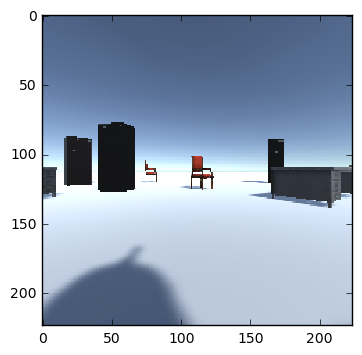

In [22]:
%matplotlib inline
plt.imshow(np.array(obs['image'][0]))

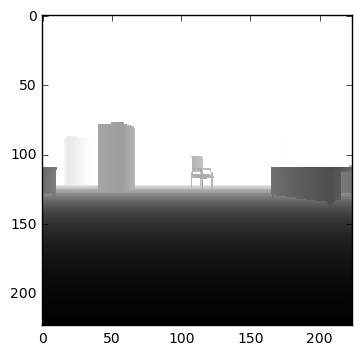

In [23]:
plt.imshow(np.array(obs['depth'][0]))

# Evaluation

In [ ]:
def Evaluation(epsilon = 0.05):
    Rs_eval = []  # past returns
    for episode in range(3):

        obs = env.reset()
        obs_processer.init_state(obs)
        chair_ids = []

#         for _ in range(random.randint(1, NO_OP_MAX)):
#             a = env.action_space.sample()
#             obs, _, _, _ = env.step(a)  # Do anything
#             obs_processer.obs2state(obs)
            
        done = False
        R = 0.0
        state = obs_processer.state   

        while not done:
            # Select an action
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = get_greedy_action(Q, state)

            # Execute an action
            new_obs, r, done, _ = env.step(a, chair_ids)

            new_state = obs_processer.obs2state(new_obs)
            
            # 椅子の検知による報酬計算
            r, chair_ids = chair_detector.calculate_reward(new_obs, info)
            R += r
            result_img = chair_detector.draw_chair()
            cv.imshow(winname, cv.cvtColor(result_img, cv.COLOR_RGB2BGR))
            cv.waitKey(1)
        
            state = new_state           

        print('Evaluation : episode: {} step: {} R:{}'.format(episode, step, R))
        Rs_eval.append(R)
    return Rs_eval

# Run

<IPython.core.display.Javascript object>


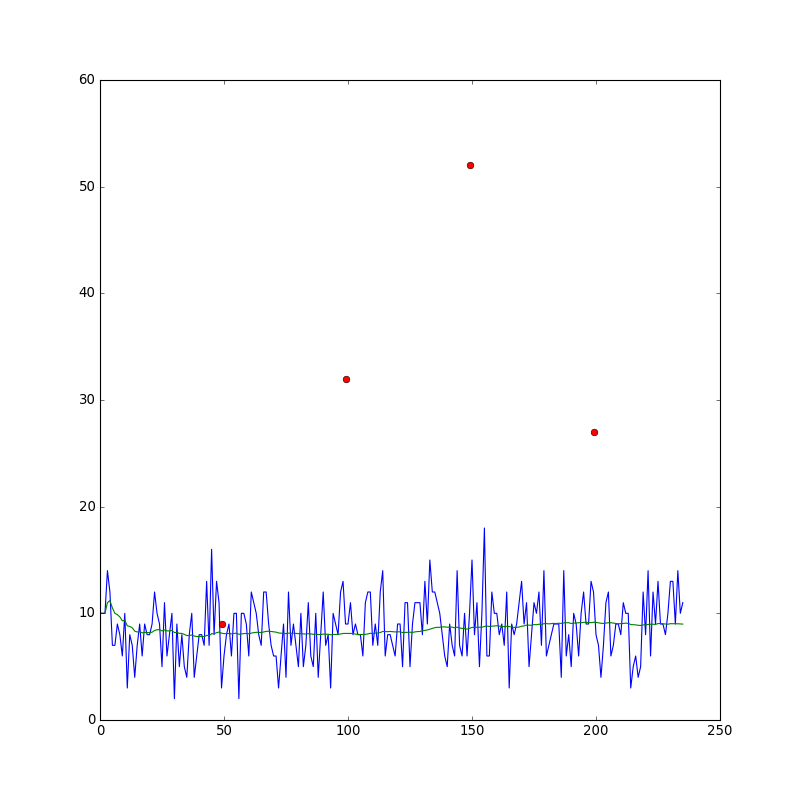

episode: 0 step: 93 R:10.0 average_R:10.0
episode: 1 step: 187 R:10.0 average_R:10.0
episode: 2 step: 281 R:10.0 average_R:10.0
episode: 3 step: 375 R:14.0 average_R:11.0
episode: 4 step: 469 R:12.0 average_R:11.2
episode: 5 step: 563 R:7.0 average_R:10.5
episode: 6 step: 657 R:7.0 average_R:10.0
episode: 7 step: 751 R:9.0 average_R:9.875
episode: 8 step: 845 R:8.0 average_R:9.66666666667
episode: 9 step: 939 R:6.0 average_R:9.3
episode: 10 step: 1033 R:10.0 average_R:9.36363636364
episode: 11 step: 1127 R:3.0 average_R:8.83333333333
episode: 12 step: 1221 R:8.0 average_R:8.76923076923
episode: 13 step: 1315 R:7.0 average_R:8.64285714286
episode: 14 step: 1409 R:4.0 average_R:8.33333333333
episode: 15 step: 1503 R:7.0 average_R:8.25
episode: 16 step: 1597 R:9.0 average_R:8.29411764706
episode: 17 step: 1691 R:6.0 average_R:8.16666666667
episode: 18 step: 1785 R:9.0 average_R:8.21052631579
episode: 19 step: 1879 R:8.0 average_R:8.2
episode: 20 step: 1973 R:8.0 average_R:8.19047619048
ep

In [ ]:
# Initialize a figure
%matplotlib notebook
fig, ax = plt.subplots(1,1)

winname = 'faster rcnn result'
cv.namedWindow(winname, cv.WINDOW_NORMAL)

while episode < M:
    obs = env.reset()
    obs_processer.init_state(obs)
    chair_ids = []

#     for _ in range(random.randint(1, NO_OP_MAX)):
#         a = env.action_space.sample()
#         obs, _, _, _ = env.step(a)  # Do anything
#         obs_processer.obs2state(obs)
    done = False
    R = 0.0
    state = obs_processer.state   
    
    while not done:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [replay_start_size, replay_start_size+steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, info = env.step(a, chair_ids)

        new_state = obs_processer.obs2state(new_obs)

        # 椅子の検知による報酬計算
        r, chair_ids = chair_detector.calculate_reward(new_obs, info)
#         if r is not 0:
#             print('detect chair reward: {}, {}'.format(r, chair_ids))
        R += r
        result_img = chair_detector.draw_chair()
        cv.imshow(winname, cv.cvtColor(result_img, cv.COLOR_RGB2BGR))
        cv.waitKey(1)

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            if step % update_inverval == 0:
                samples = random.sample(D, minibatch_size)
                update(Q, target_Q, opt, samples, target_type=target_type)

            if step % sync_interval == 0:
                mean_Q = meanQvalue(Q, samples)
                target_Q = copy.deepcopy(Q)
                print('target Q update! mean Q value : {}, epsilon:{}'.format(mean_Q, epsilon))

            if step % save_model_inverval == 0:
                save_model_filename = "lis_dqn_{}_{}.h5".format(env_name, step)
                save_model_path = os.path.join(save_folder, save_model_filename)
                print('save model : {}'.format(save_model_path))
                chainer.serializers.save_hdf5(save_model_path, Q)

        step += 1

    with open(log_file, 'a') as the_file:
        the_file.write(str(episode) + ',' + str(R) + '\n')

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    average_Rs.append(average_R)
    if episode % 1 is 0:
        print('episode: {} step: {} R:{} average_R:{}'.format(
              episode, step, R, average_R))

    # evaluation
    if (episode+1) % evaluation_interval == 0:
        R_eval = Evaluation()
        eval_Rs.append(max(R_eval))
        eval_steps.append(episode)

                
    ax.clear()
    ax.plot(Rs)
    ax.plot(average_Rs)
    ax.plot(eval_steps, eval_Rs, "o")
    fig.canvas.draw()
    episode += 1
    
env.close()